In [ ]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay('base.bit')

In [2]:
%%microblaze base.PMODA

/*This microblaze driver is a modified version of the Sparkfun V53L1X Arduino Library
  SparkFun sells these at its website: www.sparkfun.com
  https://www.sparkfun.com/products/14667
    
  This device should be connected to the G4 slot on the pmod grove adapter.
*/

#include <i2c.h>
#include <pmod_grove.h>
#include <timer.h>

/*This configuration blocked was obtained by SparkFun via inspection of the ST P-NUCLEO-53L1A1.
  When this configuration block is written to registers 1-135 (0x0001 - 0x0087) the sensor will
  begin taking measurements.
*/
unsigned char configBlock[] = {0x00, 0x01,
  0x29, 0x02, 0x10, 0x00, 0x28, 0xBC, 0x7A, 0x81,
  0x80, 0x07, 0x95, 0x00, 0xED, 0xFF, 0xF7, 0xFD,
  0x9E, 0x0E, 0x00, 0x10, 0x01, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x34, 0x00,
  0x28, 0x00, 0x0D, 0x0A, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x11,
  0x02, 0x00, 0x02, 0x08, 0x00, 0x08, 0x10, 0x01,
  0x01, 0x00, 0x00, 0x00, 0x00, 0xFF, 0x00, 0x02,
  0x00, 0x00, 0x00, 0x00, 0x00, 0x20, 0x0B, 0x00,
  0x00, 0x02, 0x0A, 0x21, 0x00, 0x00, 0x02, 0x00,
  0x00, 0x00, 0x00, 0xC8, 0x00, 0x00, 0x38, 0xFF, 
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x91, 0x0F, 
  0x00, 0xA5, 0x0D, 0x00, 0x80, 0x00, 0x0C, 0x08,
  0xB8, 0x00, 0x00, 0x00, 0x00, 0x0E, 0x10, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x01, 0x0F,
  0x0D, 0x0E, 0x0E, 0x01, 0x00, 0x02, 0xC7, 0xFF,
  0x8B, 0x00, 0x00, 0x00, 0x01, 0x01, 0x40};

static i2c device;


int initalize_device() {
    device = i2c_open(PMOD_G4_B, PMOD_G4_A);
    unsigned char index[2];
    unsigned char reg[2];
    index[0] = 0x01;
    index[1] = 0x0f;
    i2c_write(device, 0x29, index, 2);
    i2c_read(device, 0x29, reg, 2);
    return ((reg[0]<<8)| reg[1]);
}


int start_device(){
    unsigned char reg[1];
    i2c_write(device, 0x29, configBlock, 137);
    return reg[0];    
}

int check_new_data_flag(){
  //  device = i2c_open(PMOD_G4_B, PMOD_G4_A);
    unsigned char reg[1];
    unsigned char measured_flag_index[] = {0x00, 0x31};
    i2c_write(device, 0x29, measured_flag_index, 2);
    i2c_read(device, 0x29, reg, 1);
    return reg[0];
}


int read_measurement(){
  //  device = i2c_open(PMOD_G4_B, PMOD_G4_A);
    unsigned char reg[2];
    unsigned char measurement_index[] = {0x00, 0x96};
    i2c_write(device, 0x29, measurement_index, 2);
    i2c_read(device, 0x29, reg, 2);
    return ((reg[0]<<8) | reg[1]);
}

int reset_device(){
 //   device = i2c_open(PMOD_G4_B, PMOD_G4_A);
    unsigned char begin_reset[] = {0x00, 0x00, 0x00};
    unsigned char exit_reset[] = {0x00, 0x00, 0x01};
    i2c_write(device, 0x29, begin_reset, 3);
    delay_us(100);
    i2c_write(device, 0x29, exit_reset, 3);
    return 0;
}

/*
The three modes of operation are 0:short, 1:medium, 2:long. 
*/
int set_range_mode(int mode){
 //   device = i2c_open(PMOD_G4_B, PMOD_G4_A);
    unsigned char range_config_vcsel_period_a[] = {0x00, 0x60, 0x07};
    unsigned char range_config_vcsel_period_b[] = {0x00, 0x63, 0x05};
    unsigned char range_config_valid_phase_high[] = {0x00, 0x69, 0x38};
    unsigned char sd_config_dynamic[] = {0x00, 0x78, 0x07, 0x05, 0x06, 0x06};
    
    switch(mode){
        case(1):
            range_config_vcsel_period_a[2] = 0x0F;
            range_config_vcsel_period_b[2] = 0x0D;
            range_config_valid_phase_high[2] = 0x38;
            sd_config_dynamic[2] = 0x0F;
            sd_config_dynamic[3] = 0x0D;
            sd_config_dynamic[4] = 0x0A;
            sd_config_dynamic[5] = 0x0A;
        break;
        case(2):
            range_config_vcsel_period_a[2] = 0x0B;
            range_config_vcsel_period_b[2] = 0x09;
            range_config_valid_phase_high[2] = 0x78;
            sd_config_dynamic[2] = 0x0B;
            sd_config_dynamic[3] = 0x09;
            sd_config_dynamic[4] = 0x0D;
        break;
        default:
        break;
    }
    i2c_write(device, 0x29, range_config_vcsel_period_a, 3);
    i2c_write(device, 0x29, range_config_vcsel_period_b, 3);
    i2c_write(device, 0x29, range_config_valid_phase_high, 3);
    i2c_write(device, 0x29, sd_config_dynamic, 6);

    return mode;
}


In [3]:
from time import time, sleep

class V53L1X_Sensor():
    def __init__(self, address = 0x29):
        self.address = address
        self.model_id = 0xEA
        self.module_type = 0xCC
        if self._initalize() == False:
            print('Error connecting to device: Failed validation.')
        else:
            print('Connection valid.')
        self.data_history = []
        self.mode_dict = {'short':0, 'medium':1,'long':2}
        self.start_time = 0
        
    def _initalize(self):
        model_numbers = initalize_device()
        return (model_numbers == (self.model_id << 8) | self.module_type)
    
    def start(self):
        start_device()
        self.start_time = time()
    
    def reset(self):
        reset_device()
        
    def read_data(self):
        new_dp = read_measurement()
        record_time = time()
        self.data_history.append(((record_time - self.start_time), new_dp))
        return new_dp
        
    def change_range_mode(self, mode):
        if mode in self.mode_dict.keys():
            new_mode = self.mode_dict[mode]
            set_range_mode(new_mode)
        else:
            print("valid range modes are 'short', 'medium', and 'long'")
        return new_mode
    
    def clear_history(self):
        self.data_history = []
        
    def print_history(self):
        print('{:-<8}|{:-^12}|{:-^25}|{:-^25}'.format('index',
                                                         'time (s)',
                                                         'distance (meters)', 
                                                         'distance (inches)'))
        i = 0
        for time, data in self.data_history[:30]:
            i += 1
            print('{:<8}|{:<#12.3f}|{:^#25.3f}|{:^#25.3f}'.format(i,
                                                         time,
                                                         data/1000, 
                                                         data*0.0393701))

#### We now have a microblaze driver and a python class that can execute those driver functions.

In [4]:
#instantiate and start gathering data from the sensor
DS = V53L1X_Sensor()
DS.start()
print(DS.read_data()) #distance in millimeters 

Connection valid.
954


In [5]:
#Collect 20 samples.
for x in range(10):
    DS.read_data()
    sleep(.2)

DS.print_history()

index---|--time (s)--|----distance (meters)----|----distance (inches)----
1       |0.002       |          0.954          |         37.559          
2       |0.061       |          0.951          |         37.441          
3       |0.263       |          0.998          |         39.291          
4       |0.465       |          0.993          |         39.095          
5       |0.667       |          1.001          |         39.409          
6       |0.869       |          1.005          |         39.567          
7       |1.071       |          1.001          |         39.409          
8       |1.273       |          0.991          |         39.016          
9       |1.475       |          0.983          |         38.701          
10      |1.677       |          0.999          |         39.331          
11      |1.879       |          0.996          |         39.213          


In [6]:
#disable the device and clear the sample history
DS.reset()
DS.clear_history()

#### We can plot the output and change the range mode

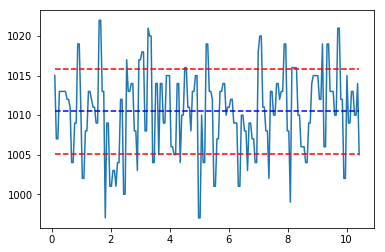

In [21]:
from numpy import std, mean
import matplotlib.pyplot as plt
%matplotlib inline

DS.reset()
DS.clear_history()

DS.start()
DS.change_range_mode('long')
sleep(.1)
    
for x in range(200):
    DS.read_data()
    sleep(.05)


x = [x for x,_ in DS.data_history]
y = [y for _,y in DS.data_history]
u_std = [mean(y) + std(y) for x in range(len(y))]
l_std = [mean(y) - std(y) for x in range(len(y))]
mean_data = [mean(y) for x in range(len(y))]

plt.plot(x,y,x,u_std, 'r--',x,l_std, 'r--',x,mean_data, 'b--')
plt.show()

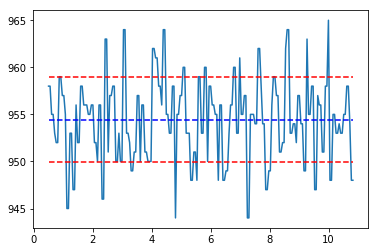

In [19]:
DS.reset()
DS.clear_history()


DS.start()
DS.change_range_mode('short')
sleep(.5)

for x in range(200):
    DS.read_data()
    sleep(.05)

x = [x for x,_ in DS.data_history]
y = [y for _,y in DS.data_history]
u_std = [mean(y) + std(y) for x in range(len(y))]
l_std = [mean(y) - std(y) for x in range(len(y))]
mean_data = [mean(y) for x in range(len(y))]

plt.plot(x,y,x,u_std, 'r--',x,l_std, 'r--',x,mean_data, 'b--')
plt.show()


In [20]:
from pprint import pprint
from pynq.lib.logictools.waveform import draw_wavedrom
trace_analyzer = base.trace_pmoda
trace_analyzer.setup(frequency_mhz=0.4, num_analyzer_samples=65535)
trace_analyzer.run()

print(DS.read_data())

trace_analyzer.stop()

_ = trace_analyzer.analyze()


trace_analyzer.set_protocol(protocol='i2c', 
                            probes={'SCL': 'D6', 'SDA': 'D2'})
start_position, stop_position = 1, 1000
waveform_lanes = trace_analyzer.decode('pmod_i2c_trace.csv', 
                                       start_position, stop_position,
                                       'pmod_i2c_trace.pd')
waveform_dict = {'signal': waveform_lanes,
                 'foot': {'tock': start_position},
                 'head': {'text': ['tspan', {'class': 'info h3'}, 
                                   'Pmod I2C Transactions']}}

pprint(trace_analyzer.get_transactions())
draw_wavedrom(waveform_dict)
trace_analyzer.reset()

956
[{'begin': 428, 'command': 'Start', 'end': 428},
 {'begin': 432, 'command': 'Address write: 29', 'end': 460},
 {'begin': 464, 'command': 'ACK', 'end': 468},
 {'begin': 468, 'command': 'Data write: 00', 'end': 500},
 {'begin': 500, 'command': 'ACK', 'end': 504},
 {'begin': 504, 'command': 'Data write: 96', 'end': 536},
 {'begin': 536, 'command': 'ACK', 'end': 540},
 {'begin': 543, 'command': 'Stop', 'end': 543},
 {'begin': 549, 'command': 'Start', 'end': 549},
 {'begin': 552, 'command': 'Address read: 29', 'end': 581},
 {'begin': 585, 'command': 'ACK', 'end': 589},
 {'begin': 589, 'command': 'Data read: 03', 'end': 621},
 {'begin': 621, 'command': 'ACK', 'end': 625},
 {'begin': 625, 'command': 'Data read: BC', 'end': 657},
 {'begin': 657, 'command': 'NACK', 'end': 661},
 {'begin': 663, 'command': 'Stop', 'end': 663}]


Values can be passed back to other microblazes, here the data is read from the sensor on PMODA and sent to a display on PMODB

In [ ]:
pmod_oled = Pmod_OLED(base.PMODB)

DS.start()
value = DS.read_data
pmod_oled.clear()
pmod_oled.write('range: {:4.4} (mm)'.format(value)